In [1]:
# Script calculates the percent of authors in a database with male, female, unisex, or unassigned names. Will count multiple authors once; accuracy of gender assignment has been validated by a (not-particuarly random) set of 100 names. cu

#system functions
from __future__ import division
import os
import sys
from datetime import datetime #system date
import csv #parse csv files? for a different functionality...
import argparse
from collections import Counter #that rad counter class

#gendering
#TO DO: replace with a more robust pip package
from genderComputer.genderComputer import GenderComputer

#parsing bibtex files
import bibtexparser as b #module for bibtex parsing, obviously
from bibtexparser.bparser import BibTexParser #add customization
from bibtexparser.customization import *

#plotting (includes matplotlib fxs in seaborn)
import numpy as np
import seaborn
import pandas as pd

#ipynb development
%matplotlib inline

In [2]:
def startUp(bib):
    #today = datetime.today()
    gc = GenderComputer(os.path.abspath('genderComputer/nameLists')) #make gendercomputer
    records = parseFile(bib)
    data = getDBCounts(records,  gc)
    return data

In [3]:
def customizations(record):
    """Use some functions delivered by the bib tex parser library
    :param record: a record
    :returns: -- customized record
    """
    record = type(record)
    #record = doi(record) TO DO: add doi functionality back into this?
    record = convert_to_unicode(record)
    record = author(record)
    return record

In [122]:
def clean_tex(s): 
    #tex files are the ~worst~
    badSubstrings = ["{","}"]
    for x in badSubstrings:
        s = s.replace(x, "")
    return s

In [5]:
def parseFile(bib_file):
    """parse the bib file

    :param bib_file: bibtex file to be parsed
    :returns: -- a bibtex file object
    """
    with open(bib_file) as bibtex_file:
        parser = BibTexParser() #import the parsers
        parser.homogenize = True
        parser.customization = customizations #add some customizations defined earlier
        data = b.load(bibtex_file, parser = parser) #process data yah!
    return data

In [6]:
### the workhorse ###
def counterFunctions(c, gc, genders=True,journals=False):
    """returns local functions to use
    C should be a counter or dictionary object"""
    if genders:
        def _countGenders(authors): 
            for author in authors:
                gender = gc.resolveGender(clean_tex(author), None) 
                #TODO: feed affiliation in as a starting place to look
                #for name assignment
                if gender == 'male': c["men"] += 1
                elif gender == 'female': c["women"] += 1
                elif gender == 'unisex': c ["unisex"] +=1
                else:
                    c["unavailable"] += 1
                    c["no_gender"].append(author)
    if journals:
        def _countJournals(entry = ""):
            return   
        """
        TODO: 
        * Add in Joel's fn to count journals w. regexes
        * needs a c["journals"] field, may not retain journal-gender link
        * needed for a OA/not OA breakdown
        """    
    return _countGenders

In [126]:
def getDBCounts(data, gc, ts=False):
    #yay, counter objects!
    c = Counter({"authorCount":0,
                "unisex":0,
                "women":0,
                "men":0,
                "unavailable":0,
                "no_author":[],
                "no_title":[],
                "no_gender":[]
                })
    #nicer to have this defined in the general function
    #gc = GenderComputer(os.path.abspath('genderComputer/nameLists')) #make gendercomputer for defining names
    #retrieve the functions
    def _countGenders(authors, c): 
        for author in authors:
            author = clean_tex(author)
            gender = gc.resolveGender(author, None) 
            #TODO: feed affiliation in as a starting place to look
            #for name assignment
            if ts:
                print author, gender
            if gender == 'male': c["men"] += 1
            elif gender == 'female': c["women"] += 1
            elif gender == 'unisex': c ["unisex"] +=1
            else: 
                c["unavailable"] += 1 #could be set with len(c["no_gender"])
                c["no_gender"].append(author)

    ##############################
    ### the actual processing ###

    for entry in data.entries: #for each paper processed
        #get titles + author lists sorted out
        title = clean_tex(entry["title"]) if "title" in entry else c["no_title"].append(entry)

        if "author" in entry:
            authors = entry["author"]
            c["authorCount"] = c["authorCount"] + len(authors)
            
        else: c["no_author"].append(title)

        _countGenders(authors, c)
        #_countJournals(c)
        #append the length of the author list to the author counts

    return c #return all the data in a counter format! it's a pain to work with I think;; or at least seaborn doesn't like it much :(

In [125]:
info = startUp('CriticalOpenNeuro.bib')
#pop = startUp('PoP_writings.bib')
#force = startUp('force_11.bib')
title = "Mapp Psyche"

Loaded dictionary from /Users/wyssuser/Documents/bibmetrics/genderComputer/nameLists/gender.dict
Finished initialization
Fleck, Ludwik male
Gorelick, Root None
Langille, Morgan G. I. unisex
Eisen, Jonathan A. male
Valsiner, Jaan unisex
Knudsen, Susanne female
Tkacz, Nathaniel male
Seth, Suman unisex
Cragin, Melissa H. female
Palmer, Carole L. female
Carlson, Jacob R. male
Witt, Michael male
Ghapanchi, Amir Hossein male
Aurum, Aybuke female
Low, Graham male
Kuhn, Thomas S. male
Kuhn, Thomas S. male
Coombe, Rosemary female
Coleman, Gabriella E. female
Choudhury, Suparna female
Slaby, Jan female
Delfanti, Alessandro male
Simonite, Tom male
Halfaker, Aaron male
Geiger, Stuart male
Morgan, Jonathan T. male
Riedl, John male
de jesus, nina female
Foucault, Michel male
Hailey, John male
Narayan, Uma female
Nafus, Dawn female
Romao, Aja female
Ortega, Francisco male
Release, CERN Press None
Nkrumah, Kwame male
Dahdouh-Guebas, Farid male
Ahimbisibwe, Jennifer female
Van Moll, Rita female
Koedam,

In [108]:
def makeSeries(d):
    counts ={'men':0, 'women':0, 'unisex':0, 'unavailable':0}
    for key in counts:
            counts[key] = d[key]
    return pd.Series(counts) 
    #return series

In [102]:
def setPalettes(series, title, palette="Set3", style="darkgrid", context="talk"):
    seaborn.set_palette(palette)
    seaborn.set_style(style)
    seaborn.set_context(context)
    series.plot.pie(title=title, figsize=(6, 6),autopct='%1.f%%',
                    shadow=True)

In [127]:
hall = makeSeries(startUp('hallucinogens.bib'))

Loaded dictionary from /Users/wyssuser/Documents/bibmetrics/genderComputer/nameLists/gender.dict
Finished initialization


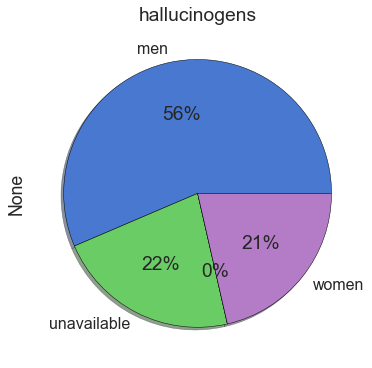

In [128]:
setPalettes(hall, "hallucinogens", "muted", context="poster")

In [100]:
if __name__ == '__main__':
    d = startUp(sys.argv[1]) #analyze the provided bib file
    if sys.argv[2]:
        title = sys.argv[2]
    else:
        title = "Gender analysis of" + sys.argv[1]
    barChartData(d, )
    counts ={'men':0, 'women':0, 'unisex':0, 'unavailable':0,}
    for key in counts:
        counts[key] = d[key]
    seaborn.set(style="whitegrid")

    fig = saveseries.plot(kind='')
    fig.savefig("gender count")

# """
# TODO: more maintained gender calculator?
# TODO: turn hacky stats into a function; decide if I want this to be a script or more interactive
#
# ##########################
# ###Old Stuff###
#
# for key in stats:
#     value = stats[key]
#     percent = value/auCount*100 #probably should fix so it can't break if dividing by zero
#     percents[key] = percent
#
#
# print stats
# print percents
# print auCount
#
# plt.bar(range(len(stats)), percents.values(), align='center', color="#2aa198")
# plt.xticks(range(len(percents)), percents.keys(), color="#657b83")
# plt.xlabel('Genders' + '\n' +  '(plot generated ' + 'May 14 2015' +')', color="#073642")
# plt.ylabel('"""', color="#073642")
#
#
# #plt.show()
# """"

SyntaxError: invalid syntax (<ipython-input-100-c1249dcc97ab>, line 1)